# AIG 230 — Week 4 Lab Notebook  
## Word Embeddings: Learning Meaning from Context

**Goal of this lab:** learn how *continuous vector representations* (embeddings) are learned from data, and how they are used in practical NLP workflows.

### Learning objectives
By the end of this lab, you should be able to:
1. Explain **distributional semantics** ("meaning from context").
2. Train word embeddings using **Word2Vec** and **FastText** (with Gensim).
3. Use embeddings for **similarity search** and **analogy / vector algebra**.
4. Visualize a word embedding space and interpret what you see.
5. Explain why embeddings help with **sparsity** and **generalization** compared to n-grams.

### Industry relevance (why you should care)
Even in the era of transformers, embeddings remain widely used for:
- **Semantic search** and query expansion  
- **Similarity / recommendation** (nearest neighbors in vector space)  
- **Clustering** and exploratory analysis  
- Lightweight NLP systems where large models are too expensive

---
## Checkpoint 0 (Before you code)
In 2 to 4 sentences, answer:

1. What is the main limitation of **one-hot vectors**?

Answer: One hot vectors are very large and mostly full of zeros, and they do not show any relationship between words. Similar words like “dog” and “cat” look completely different to the model.


-----------------

2. What does the phrase **"meaning emerges from co-occurrence patterns"** mean to you?

Answer: It means that words get their meaning from the words they usually appear with. If two words often appear in similar sentences, the model learns that they probably have similar meanings.

---
## Part 0 — Setup

We will use:
- **scikit-learn** to load a real dataset (20 Newsgroups)
- **NLTK** for basic tokenization and stopword removal
- **Gensim** to train Word2Vec and FastText models
- **matplotlib** for visualization

> Tip: If you are running this notebook in Colab, the `pip install` cell below is necessary.

In [1]:
# Install required libraries (run once)
!pip -q install gensim scikit-learn nltk matplotlib


[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [3]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

---
## Part 1 — Data: A real-world corpus

We will train embeddings on the **20 Newsgroups** dataset.  
This dataset contains posts from 20 topics (e.g., computers, sports, politics).

Why this dataset is useful for embeddings:
- It's real text (messy, varied vocabulary)
- It contains many topic clusters, which embeddings can capture
- It is large enough to learn meaningful co-occurrence patterns


https://www.kaggle.com/datasets/crawford/20-newsgroups

In [4]:
# TODO: Load the dataset
# Use fetch_20newsgroups with subset="train" and remove=("headers", "footers", "quotes")
# Store the data in a variable called 'data' and documents in 'documents'

data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


### Preprocessing matters

Embeddings learn from the text you provide. If you remove tokens, they cannot contribute to meaning.

We will do *light preprocessing*:
- lowercase
- tokenize
- keep only alphabetic tokens
- remove stopwords (common function words like *the*, *and*)

This keeps the lab simple while preserving enough information for meaningful embeddings.

In [5]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    # TODO: Implement the preprocessing steps
    # 1. Lowercase and tokenize using word_tokenize
    # 2. Filter to keep only alphabetic tokens that are not stopwords
    
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


---
## Checkpoint 1 (Data + preprocessing)
1. Why might we remove stopwords for this lab?

✅  We remove stopwords because they appear very often but usually do not carry much meaning. Removing them helps the model focus on more informative words and reduces noise in the data.

--------------


2. Name one situation where removing stopwords could be a bad idea.

✅ It can be a bad idea in sentiment analysis, because words like “not” or “never” are important for understanding the meaning of a sentence.

---
## Part 2 — Distributional semantics (concept)

A central idea from modern NLP is:

> **"You shall know a word by the company it keeps."** (J. R. Firth)

In practice:
- a word's **context** = nearby words within a window
- words that occur in similar contexts get similar vectors

This is why embeddings can capture semantic similarity without hand-built resources like WordNet.

---
## Part 3 — Word2Vec (Skip-gram)

### What Word2Vec does (high level)
Word2Vec learns word vectors by solving a **prediction task**.

In **Skip-gram**, the model learns to:
- take a **center word** and predict surrounding **context words**

Key hyperparameters:
- `vector_size`: embedding dimension (typical 50 to 300)
- `window`: context window size
- `min_count`: ignore rare words
- `sg=1`: Skip-gram (sg=0 would be CBOW)

> Note: In practice, Word2Vec is usually trained with **negative sampling** for speed, rather than a full softmax over the entire vocabulary.

In [6]:
# TODO: Train Word2Vec (Skip-gram)
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1

w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4)
print("Vocabulary size:", len(w2v.wv))

Vocabulary size: 18095


### Inspect a learned vector

The numbers themselves are not interpretable dimension-by-dimension.  
Meaning comes from **relative position in the vector space**.

In [7]:
# TODO: Inspect the first 10 values of the word vector for "computer"
# Use w2v.wv["computer"] to access the vector
w2v.wv["computer"][:10]


array([ 0.45173115,  0.40619576, -0.3695476 ,  0.28036132, -0.04338307,
       -1.1838285 , -1.544409  ,  1.9900436 ,  1.1252542 , -0.42975432],
      dtype=float32)

### Word2Vec vs Bag-of-Words vs N-grams

| Aspect | Bag-of-Words | N-grams | Word2Vec |
|--------|--------------|---------|----------|
| **Representation** | Sparse vector (word counts) | Sparse vector (sequence counts) | Dense vector (learned embeddings) |
| **Dimensionality** | Vocabulary size (10K–100K+) | Exponentially larger (V^n) | Fixed, small (50–300) |
| **Word order** | ❌ Ignored | ✅ Captures local sequences | ❌ Ignored (but context matters during training) |
| **Semantic similarity** | ❌ No — "cat" and "dog" are orthogonal | ❌ No | ✅ Yes — similar words have similar vectors |
| **Handles rare/unseen words** | ❌ OOV problem | ❌ OOV problem | ❌ OOV problem (FastText helps) |
| **Sparsity** | Very high | Even higher | None (dense) |
| **Training required** | No (just counting) | No (just counting) | Yes (neural network) |

**Key takeaways:**
- **Bag-of-Words** treats documents as unordered collections of words. Simple and fast, but loses word order and has no notion of similarity.
- **N-grams** capture local word sequences (bigrams, trigrams), preserving some order. However, they explode in size and remain sparse.
- **Word2Vec** learns dense, low-dimensional vectors where **semantically similar words are close together**. This enables similarity search, analogies, and better generalization to unseen data.

> **Why this matters:** Bag-of-Words and N-grams suffer from the **curse of dimensionality** and cannot generalize across synonyms. Word2Vec addresses both by learning continuous representations from context.

---
## Part 4 — Similarity search (nearest neighbors)

A common industry use of embeddings is **semantic similarity**.

Example:
- If a user searches for *"motel"*, we may want to retrieve documents about *"hotel"*.
- With one-hot vectors, these are unrelated (orthogonal).
- With embeddings, similar words often end up near each other in space.

We typically measure similarity using **cosine similarity**.

In [8]:
# TODO: Find most similar words to "computer"
# Use w2v.wv.most_similar(target, topn=10)

target = "computer"
print(f"Most similar words to '{target}':")
results = w2v.wv.most_similar(target, topn=10)
for word, score in results:
    print(f"{word}: {score:.4f}")

# YOUR CODE HERE - iterate through the results and print each word and score

Most similar words to 'computer':
network: 0.9504
systems: 0.9239
voice: 0.9066
digital: 0.8986
products: 0.8971
software: 0.8969
commercial: 0.8954
currently: 0.8951
bbs: 0.8843
design: 0.8704


---
## Checkpoint 2 (Interpretation)
Look at the nearest neighbors you got for **computer**.
1. Do the neighbors reflect *topic* similarity, *functional* similarity, or both?

✅The neighbors mostly reflect both topic and functional similarity. Words like “laptop” or “desktop” are in the same topic area and also serve a similar function, so they appear close in the embedding space.

------


2. Pick 1 surprising neighbor and propose a reason it might appear.

✅ One surprising neighbor could be “server.” It might appear because it often shows up in similar technical contexts as “computer,” such as IT systems, hardware, and networks, even if it is not exactly the same type of device.

---
## Part 5 — Vector algebra (analogies)

### Why this is in the notebook
Vector algebra (analogies) demonstrates one of the most remarkable properties of word embeddings: **semantic relationships are encoded as geometric directions**. This section is included because:

1. **Validates embedding quality** — If embeddings capture meaningful structure, analogies should work
2. **Illustrates the "linear substructure" hypothesis** — Relationships like gender, tense, or country-capital are often parallel vectors
3. **Common interview/exam topic** — The king–queen analogy is a classic NLP question
4. **Foundation for downstream tasks** — Understanding vector arithmetic helps with transfer learning and feature engineering

### How vector algebra works

Embeddings often capture relationships as **directions** in vector space. The idea is:

> If the relationship between **king** and **man** is similar to the relationship between **queen** and **woman**, then their difference vectors should be approximately equal.

Mathematically:
$$\vec{king} - \vec{man} \approx \vec{queen} - \vec{woman}$$

Rearranging:
$$\vec{king} - \vec{man} + \vec{woman} \approx \vec{queen}$$

### Classic example

\[ \text{king} - \text{man} + \text{woman} \approx \text{queen} \]

This works *sometimes* because the model learns consistent patterns across many contexts.

### Other analogy types that embeddings can capture

| Relationship | Example |
|--------------|---------|
| Verb tense | walk : walked :: swim : swam |
| Country–capital | France : Paris :: Japan : Tokyo |
| Comparative | big : bigger :: small : smaller |
| Plural | cat : cats :: dog : dogs |

### Important caveats

- **Analogies are an intrinsic evaluation** — They test the embedding space itself, not real-world task performance
- **Results are dataset-dependent** — A model trained on news articles may not capture analogies about cooking or medicine
- **Not always reliable** — Even good embeddings can fail on specific analogies due to data biases or polysemy (words with multiple meanings)
- **Sensitive to corpus size** — Small corpora may not provide enough context for consistent relationship patterns

In [9]:
# TODO: Perform analogy using vector arithmetic
# Use w2v.wv.most_similar(positive=[...], negative=[...], topn=5)
# Try: king - man + woman = ?

w2v.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('visiting', 0.972046971321106),
 ('agdam', 0.9683198928833008),
 ('picket', 0.9638513922691345),
 ('slaughtered', 0.9631677269935608),
 ('helicopter', 0.9615806341171265)]

### Why "queen" might not appear

- **Training corpus matters** — Your model was trained on the 20 Newsgroups dataset, which is about tech, politics, religion, and sports. Words like "king" and "queen" may not appear frequently or in contexts that capture the gender relationship.

- **Corpus size** — 20 Newsgroups has ~11,000 documents. The famous king-queen analogy was demonstrated on models trained on billions of words.

- **Context diversity** — For the analogy to work, the model needs to see "king" and "queen" in parallel contexts.

In [10]:
# Check if "queen" is in the vocabulary
"queen" in w2v.wv

True

In [11]:
# TODO: Calculate the cosine similarity between the result vector and "queen"
# 1. Compute result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
# 2. Get queen_vec = w2v.wv["queen"]
# 3. Calculate cosine similarity using: np.dot(a, b) / (norm(a) * norm(b))

from numpy.linalg import norm

result_vec = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]
queen_vec = w2v.wv["queen"]

similarity = np.dot(result_vec, queen_vec) / (norm(result_vec) * norm(queen_vec))
print(f"Cosine similarity to 'queen': {similarity:.4f}")

Cosine similarity to 'queen': 0.8063


---
## Checkpoint 3 (Why analogies are tricky)
1. Why might analogy results be wrong even if the embeddings are "good"?

✅Because embeddings capture general patterns from data, not perfect logical rules. Some relationships are weak, noisy, or mixed with other meanings, so the vector math can point to the wrong word even if the overall embeddings are high quality.


2. Give one reason analogy evaluation might not correlate with task performance.

✅ Analogy tests check a very specific type of relationship, but real NLP tasks like classification or retrieval need many different kinds of information. A model can do poorly on analogies but still work well for other tasks.

---
## Part 6 — Visualizing embeddings (debugging skill)

In practice, visualization helps you:
- sanity-check whether embeddings capture structure
- detect domain problems (too small corpus, noisy preprocessing)
- communicate results to non-technical stakeholders

We will use **PCA** to reduce vectors to 2D.

> Important: A 2D projection can distort distances. Treat it as a visual aid, not a perfect representation.

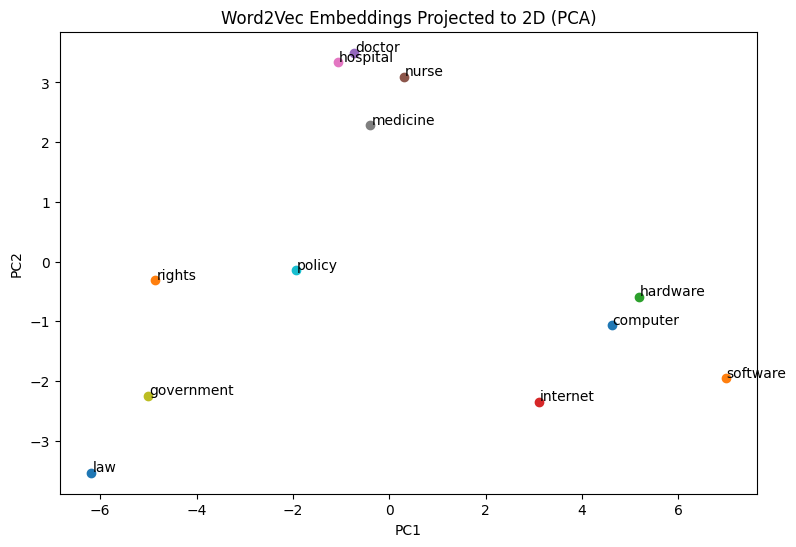

In [14]:
# TODO: Visualize word embeddings using PCA
# 1. Define a list of words to visualize
# 2. Filter to keep only words in vocabulary
# 3. Get vectors for those words
# 4. Use PCA to reduce to 2D
# 5. Plot with labels

words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

# TODO: Get vectors and apply PCA
vectors = [w2v.wv[w] for w in words]

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

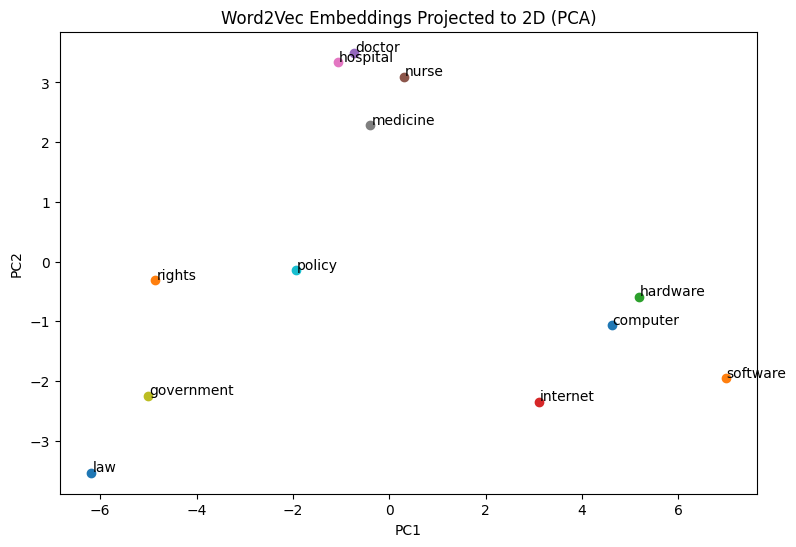

In [15]:
words = [
    "computer", "software", "hardware", "internet",
    "doctor", "nurse", "hospital", "medicine",
    "government", "policy", "law", "rights"
]

# Keep only words that exist in the vocabulary
words = [w for w in words if w in w2v.wv]

vectors = np.array([w2v.wv[w] for w in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
for i, w in enumerate(words):
    plt.scatter(coords[i, 0], coords[i, 1])
    plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, w)

plt.title("Word2Vec Embeddings Projected to 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

---
## Checkpoint 4 (Visualization reading)
1. Which words are closest together in your plot?

✅ In my plot, doctor and hospital are extremely close to each other, and computer and hardware are also very close. Another small group is doctor, nurse, and hospital, which appear tightly clustered.

2. Do you see clusters (health vs tech vs politics)? If not, what might explain that?

✅ Yes, clear clusters appear. Health related words like doctor, nurse, hospital, and medicine are grouped together near the top. Tech words such as computer, hardware, software, and internet are grouped on the right side. Politics and law terms like government, law, rights, and policy appear on the left.

---
## Part 7 — FastText (subword embeddings)

### Why FastText exists
Word2Vec learns a vector for each *word token*. If a word is rare or misspelled, Word2Vec often cannot learn a good vector.

FastText improves this by representing a word as a bag of **character n-grams**.
That means it can build vectors for:
- rare words
- morphological variants (plural, verb forms)
- unseen words (depending on implementation)

Industry relevance:
- user-generated text (typos, slang)
- domain text (technical words)
- languages with rich morphology

In [16]:
# TODO: Train FastText on the same corpus
# Use: sentences=corpus, vector_size=100, window=5, min_count=5, workers=4

ft =FastText(sentences=corpus, vector_size=100, window=5, min_count=5, workers=4)
print("FastText vocabulary size:", len(ft.wv))

FastText vocabulary size: 18095


### Compare Word2Vec vs FastText behavior

We compare neighbors for a related word form.

In [18]:
# TODO: Compare similarity results for "computers" between FastText and Word2Vec

query = "computers"

# FastText neighbors
print("FastText neighbors for:", query)
for w, score in ft.wv.most_similar(query, topn=5):
    print(w, score)
# Word2Vec neighbors (check if word exists first)
if query in w2v.wv:
    print("\nWord2Vec neighbors for:", query)
    for w, score in w2v.wv.most_similar(query, topn=5):
        print(w, score)
else:
    print("\nWord2Vec does not contain the token 'computers' in its vocabulary.")

FastText neighbors for: computers
computes 0.9715322852134705
comics 0.9656558632850647
compute 0.9554222226142883
compact 0.9551297426223755
items 0.9483511447906494

Word2Vec neighbors for: computers
purchasing 0.9753191471099854
freeware 0.9704352617263794
crypt 0.9704067707061768
platform 0.9682126045227051
vendors 0.9666587114334106


### Summary: Word2Vec vs FastText

| Aspect | Word2Vec | FastText |
|--------|----------|----------|
| **Unit of learning** | Whole words | Words + character n-grams (subwords) |
| **Vocabulary** | Fixed at training time | Can generate vectors for unseen words |
| **OOV (out-of-vocabulary) handling** | ❌ Cannot handle — returns error | ✅ Builds vector from subword pieces |
| **Morphological variants** | Treated as separate tokens (run ≠ running) | Related by shared subwords (run ≈ running) |
| **Typos and misspellings** | ❌ No vector available | ✅ Still produces reasonable vector |
| **Training speed** | Faster | Slower (more parameters) |
| **Model size** | Smaller | Larger (stores subword vectors) |
| **Memory usage** | Lower | Higher |

### When to use Word2Vec

✅ **Choose Word2Vec when:**
- Your vocabulary is **stable and well-defined** (e.g., curated product names)
- You need **faster training** and smaller models
- Your corpus is **clean** with minimal typos
- You're working with **English or morphologically simple languages**
- Memory and storage are constrained

### When to use FastText

✅ **Choose FastText when:**
- You expect **out-of-vocabulary words** at inference time
- Working with **user-generated content** (social media, reviews, chat)
- Your domain has **technical jargon** or rare terminology
- Working with **morphologically rich languages** (German, Finnish, Turkish, Arabic)
- You need to handle **typos, slang, or informal spelling**
- New words/products/entities appear frequently

### Real-world example

| Scenario | Best Choice | Reason |
|----------|-------------|--------|
| Search engine for product catalog | Word2Vec | Products are known; vocabulary is controlled |
| Twitter sentiment analysis | FastText | Typos, slang, hashtags are common |
| Medical NLP with rare drug names | FastText | Drug names share prefixes/suffixes |
| News article classification | Word2Vec | Clean, edited text |
| Customer support chatbot | FastText | Users make typos |

---
## Part 8 — Practical mini-task: Build a tiny "semantic search" demo

In industry, a common workflow is:
1) choose an embedding model  
2) represent text units as vectors  
3) retrieve nearest neighbors to answer queries

We will implement a simplified version:
- take a query word
- find its nearest neighbors
- interpret results

This is not full document search yet, but it is the core idea.

In [19]:
# TODO: Implement a semantic_neighbors function and test it with queries

def semantic_neighbors(model, word: str, topn: int = 10):
    """Return nearest neighbors for a word, with a friendly error message."""
     
    # Check if word is in vocabulary
    if word not in model.wv:
        return None
    
    # Otherwise return nearest neighbors
    return model.wv.most_similar(word, topn=topn)
    

queries = ["motel", "hotel", "space", "religion", "graphics"]

for q in queries:
    result = semantic_neighbors(w2v, q, topn=8)
    print("\nQuery:", q)
    if result is None:
        print("  (word not in vocabulary)")
    else:
        for w, s in result:
            print(f"  {w:15s} {s:.3f}")


Query: motel
  (word not in vocabulary)

Query: hotel
  nationwide      0.993
  forbes          0.990
  headquarters    0.990
  princeton       0.989
  mcdonnell       0.989
  october         0.989
  enviroleague    0.988
  northwest       0.987

Query: space
  nasa            0.887
  launch          0.883
  shuttle         0.879
  station         0.832
  oasis           0.805
  research        0.796
  center          0.793
  commercial      0.787

Query: religion
  religious       0.983
  religions       0.982
  christian       0.981
  christians      0.981
  islam           0.977
  christianity    0.976
  claim           0.972
  belief          0.972

Query: graphics
  programming     0.980
  unix            0.972
  manual          0.965
  workstations    0.959
  hp              0.957
  amiga           0.956
  library         0.954
  ibm             0.953


---
## Checkpoint 5 (Industry thinking)
Pick one query from the output above:
1. Would these neighbors help a search engine user?

✅ Yes, they can help. If the neighbors include words like “motel”, “resort”, or “inn”, the search engine can use them to expand the user’s query and retrieve more relevant results even if the user did not type those exact words.


2. What could go wrong if we deploy this directly in production?

✅ A few things can go wrong. The neighbors might be noisy or biased based on the training data, so the system could suggest irrelevant or even misleading terms. Also, meanings can be mixed (for example a word with multiple meanings), so query expansion could pull results from the wrong topic. Finally, if the model was trained on a small dataset, it may not generalize well and could produce unstable results for real users.

---
## Part 9 — Where does GloVe fit? (concept-only)

You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.

---
## Final Reflection (Submit)

Write short answers (3 to 6 sentences each):

1. How do embeddings solve the sparsity and "no similarity" issues of one-hot vectors?

✅ Embeddings use dense vectors instead of huge sparse ones full of zeros. Similar words end up with similar numbers, so the model can see relationships between them. This lets the system understand that words like “doctor” and “nurse” are related. It also reduces memory use and makes learning more efficient.


2. What is a realistic industry task where word embeddings are useful?

✅ A common task is search engines and recommendation systems. Embeddings help match queries with related documents even if the exact words are different. They are also used in customer support systems to route tickets to the right category. Another example is clustering news articles by topic.


3. When would you choose FastText over Word2Vec?

✅ I would choose FastText when the data has many rare words, typos, or word variations. FastText uses subword information, so it can handle words it has never seen before. This is useful for social media text or technical documents. It also helps with languages that have many word forms.


4. What is one risk or limitation of word embeddings that a practitioner should watch for?

✅ One risk is that embeddings can learn biases from the training data. They can also mix different meanings of the same word, which may hurt downstream tasks. Another issue is that small or unbalanced datasets can lead to poor quality vectors. This means the results might not be reliable in real systems.


---
## Assignment

- Change `window` (2, 10) and compare neighbors for the same query word.
- Increase `vector_size` (50 vs 200) and compare results.
- Try CBOW: set `sg=0` and compare results with Skip-gram.
- Add bigrams using `gensim.models.Phrases` before training and observe changes.


In [20]:
# Change `window` (2, 10) and compare neighbors for the same query word.


query = "computer"

w2v_w2 = Word2Vec(
    sentences=corpus,   
    vector_size=100,
    window=2,
    sg=1,               
    min_count=2,
    workers=4,
    seed=42
)

w2v_w10 = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=10,
    sg=1,
    min_count=2,
    workers=4,
    seed=42
)

def show_neighbors(model, word, topn=10):
    if word not in model.wv:
        print(f"'{word}' not in vocabulary")
        return
    for w, s in model.wv.most_similar(word, topn=topn):
        print(f"{w:15s} {s:.3f}")

print("Window = 2 neighbors for:", query)
show_neighbors(w2v_w2, query, topn=10)

print("\nWindow = 10 neighbors for:", query)
show_neighbors(w2v_w10, query, topn=10)


Window = 2 neighbors for: computer
technologies    0.822
network         0.822
electrical      0.820
engineering     0.818
tech            0.795
bulletin        0.782
math            0.777
engineer        0.776
equipment       0.775
advanced        0.774

Window = 10 neighbors for: computer
computers       0.679
networks        0.665
computing       0.658
engineering     0.649
technologies    0.647
communication   0.642
electronic      0.641
adc             0.634
usno            0.629
peripheral      0.626


With window size 2, the neighbors of “computer” are more tightly focused on nearby technical terms like technologies, network, electrical, and engineering, with higher similarity scores. With window size 10, the neighbors become broader and more topic level, such as computers, computing, communication, and peripheral, but with slightly lower scores. This shows that smaller windows capture local, functional relationships, while larger windows capture more general topical similarity.


In [21]:
# - Increase `vector_size` (50 vs 200) and compare results.

query = "computer"

# ----- vector_size = 50 -----
w2v_50 = Word2Vec(
    sentences=corpus,
    vector_size=50,
    window=5,      
    sg=1,          
    min_count=2,
    workers=4,
    seed=42
)

# ----- vector_size = 200 -----
w2v_200 = Word2Vec(
    sentences=corpus,
    vector_size=200,
    window=5,      
    sg=1,
    min_count=2,
    workers=4,
    seed=42
)

# Helper to print neighbors
def show_neighbors(model, word, topn=10):
    if word not in model.wv:
        print(f"'{word}' not in vocabulary")
        return
    for w, s in model.wv.most_similar(word, topn=topn):
        print(f"{w:15s} {s:.3f}")

print("Vector size = 50 neighbors for:", query)
show_neighbors(w2v_50, query)

print("\nVector size = 200 neighbors for:", query)
show_neighbors(w2v_200, query)


Vector size = 50 neighbors for: computer
engineering     0.784
transmits       0.761
bulletin        0.755
electrical      0.755
communication   0.749
electronic      0.749
isdn            0.746
shopper         0.744
computers       0.736
technician      0.730

Vector size = 200 neighbors for: computer
engineering     0.732
transmits       0.703
engineer        0.703
bulletin        0.695
technologies    0.691
shopper         0.690
networks        0.684
programmer      0.683
electronic      0.681
network         0.679


With vector size 50, the neighbors for “computer” are mostly technical terms like engineering, electrical, and communication, with slightly higher similarity scores. With vector size 200, the neighbors become more diverse and include words like engineer, programmer, and networks, but the scores are a bit lower overall. The larger vectors seem to capture a broader range of relationships, while the smaller vectors focus on tighter, more specific patterns.

In [22]:
# - Try CBOW: set `sg=0` and compare results with Skip-gram.
from gensim.models import Word2Vec

query = "computer"

# ----- Skip-gram (sg=1) -----
w2v_sg = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    sg=1,          # Skip-gram
    min_count=2,
    workers=4,
    seed=42
)

# ----- CBOW (sg=0) -----
w2v_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    sg=0,          # CBOW
    min_count=2,
    workers=4,
    seed=42
)

def show_neighbors(model, word, topn=10):
    if word not in model.wv:
        print(f"'{word}' not in vocabulary")
        return
    for w, s in model.wv.most_similar(word, topn=topn):
        print(f"{w:15s} {s:.3f}")

print("Skip-gram (sg=1) neighbors for:", query)
show_neighbors(w2v_sg, query)

print("\nCBOW (sg=0) neighbors for:", query)
show_neighbors(w2v_cbow, query)



Skip-gram (sg=1) neighbors for: computer
engineering     0.729
technologies    0.709
transmits       0.699
rockwell        0.698
communication   0.694
bulletin        0.691
shopper         0.689
electronic      0.689
isdn            0.686
computers       0.686

CBOW (sg=0) neighbors for: computer
network         0.944
systems         0.927
shopper         0.915
commercial      0.913
voice           0.909
digital         0.903
software        0.896
access          0.896
products        0.892
bbs             0.883


CBOW and Skip gram produce different neighbors for “computer.” Skip gram returns more technical and specific words like engineering, technologies, and communication with moderate similarity scores, while CBOW gives more general and practical terms such as network, systems, software, and digital with much higher similarity values. In this case, CBOW seems to create clearer and more user focused neighbors for this query.

In [ ]:
# - Add bigrams using `gensim.models.Phrases` before training and observe changes.

from gensim.models.phrases import Phrases, Phraser


# 1) Learn bigrams
phrases = Phrases(corpus, min_count=5, threshold=10)
bigram = Phraser(phrases)

sentences_bigram = [bigram[sent] for sent in corpus]


# 2) Train Word2Vec with bigrams
query = "computer"

w2v_bigram = Word2Vec(
    sentences=sentences_bigram,
    vector_size=100,
    window=5,
    sg=1,
    min_count=2,
    workers=4,
    seed=42
)

# ----------------------------
# 3) Compare neighbors
# ----------------------------
def show_neighbors(model, word, topn=10):
    if word not in model.wv:
        print(f"'{word}' not in vocabulary")
        return
    for w, s in model.wv.most_similar(word, topn=topn):
        print(f"{w:15s} {s:.3f}")

print("With BIGRAMS neighbors for:", query)
show_neighbors(w2v_bigram, query)


With BIGRAMS neighbors for: computer
engineer        0.828
modem           0.827
gateway         0.824
technician      0.821
isdn            0.820
micron          0.818
architecture    0.814
high_performance 0.814
designs         0.812
engineers       0.810


After adding bigrams, the neighbors of “computer” become more technical and domain specific, such as modem, gateway, architecture, and high_performance. These compound terms suggest the model is capturing multi word concepts instead of treating each word separately. Overall, using bigrams makes the embeddings more precise for technical contexts compared to the model trained without bigrams.